<a href="https://colab.research.google.com/github/adalbertii/Seci-konwolucyjne/blob/main/CNN_brain_tumor_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model klasyfikacji binarnej**

- transfer learning
- Liczba parametrów podlegajaca procesowi uczenia :
       łącznie : 27 560 769
       podlegających uczeniu: 12 846 081
       zamrożonych : 14 714 688 (wykorzystanie modelu wstępnie wytrenowanego **VG16**)

- Czas procesu uczenia (przy wykorzystaniu procesora graficznego  T4 GPU) : 3 s na 1 epokę (łącznie 50 epok)

- Accuracy (dane testowe) na poziomie:  0.80


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt

# -----------------------------------------------------
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
# -----------------------------------------------------

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# -----------------------------------------------------
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

import warnings
warnings.filterwarnings("ignore")


In [ ]:
!apt-get install tree


# utworzenie pomocniczej struktury katalogowej w maszynie wirtualnej Notebook-a
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
#!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 8s (5,670 B/s)
Selecting previously unselected package tree.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# zbiór danych jest zapisany na dysku Google
IMG_PATH = '/content/drive/MyDrive/dane/BrainTumor/'

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# pobranie danych z Google Drive i
# podział danych na  train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)


# ---- > sprawdzić zawartość struktury katalogowej TEST/TRAIN/VAL

In [ ]:

# definicja funkcji pomocniczych
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def load_data(dir_path, img_size=(100,100)):
    """
    Załadowanie obrazów o zmienionym rozmiarze jako np.arrays do obszaru roboczego
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} obrazy zaladowane z  {dir_path} katalogu.')
    return X, y, labels


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Funkcja tworzy wykres konfuzji.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True etykieta')
    plt.xlabel('Predicted etykieta')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'



#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ustalenie stałego , ujednoliconego rozmiaru zdjęcia
IMG_SIZE = (224,224)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




# wykorzystanie zdefiniowanej powyżej funkcji do zainicjowania zmiennych X_train, y_train...
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


193 obrazy zaladowane z  TRAIN/ katalogu.


100%|██████████| 2/2 [00:00<00:00, 64.33it/s]


10 obrazy zaladowane z  TEST/ katalogu.


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]

50 obrazy zaladowane z  VAL/ katalogu.


In [ ]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# definicja pomocniczej funkcji do wyświetlania grupy zdjęć

def plot_samples(X, y, labels_dict, n=50):
    """
    Tworzy wykres siatkowy dla żądanej liczby obrazów (n)
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Nowotwór: {}'.format(labels_dict[index]))
        plt.show()

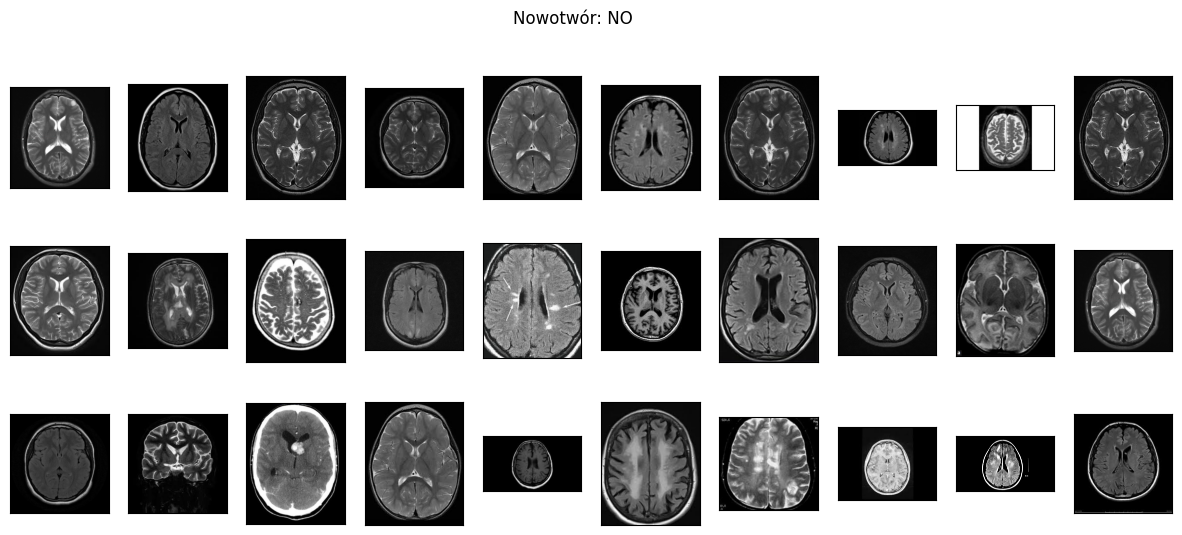

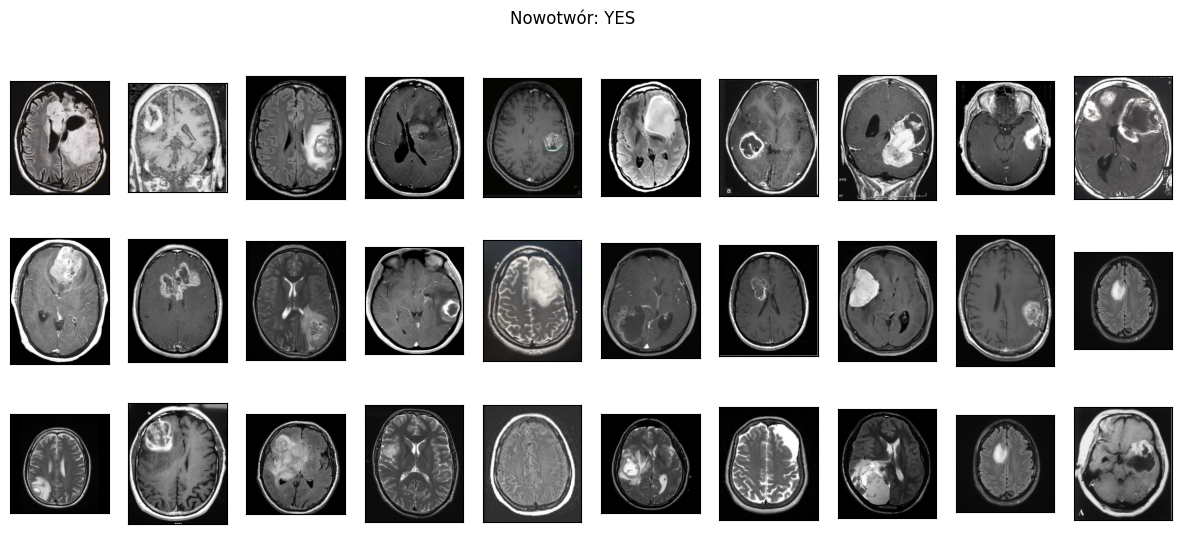

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
nimg = 20 # liczba ozdjęć do wyswietlenia
plot_samples(X_train, y_train, labels, nimg)

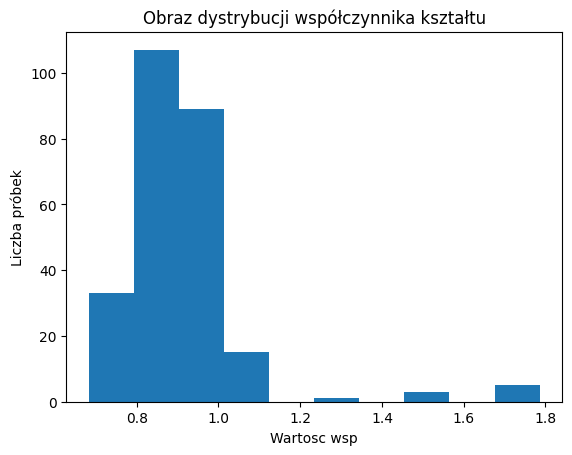

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# wykres (Histogram)   współczynników kształtu zdjęć znajdujących się w zbiorze źródlowym
# wsp_kształtu = width/height

RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Obraz dystrybucji współczynnika kształtu')
plt.xlabel('Wartosc wsp')
plt.ylabel('Liczba próbek')
plt.show()



In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# definicja pomocniczej funkcji do normalizacji zdjęć

def crop_imgs(set_name, add_pixels_value=0):
    """
    Znajduje skrajne punkty na obrazie i wycina z nich prostokąt.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)


        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)


        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)


        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

**Symulacja procesu normalizacji zdjęć**

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# proces:
# - wyznaczania konturu zdjecia
# - wyznaczania skrajnych punktów konturu
# - przycinania zdjęć do granic określonych prze wyznaczone skrajne punkty konturów

# --------------------------------------------------------------
# przykładowe zdjęcia do zaprezentowania procesu przycinania
img = cv2.imread('/content/drive/MyDrive/dane/BrainTumor/yes/Y108.jpg')
# --------------------------------------------------------------

img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)


cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)


extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])


img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)


img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)


ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

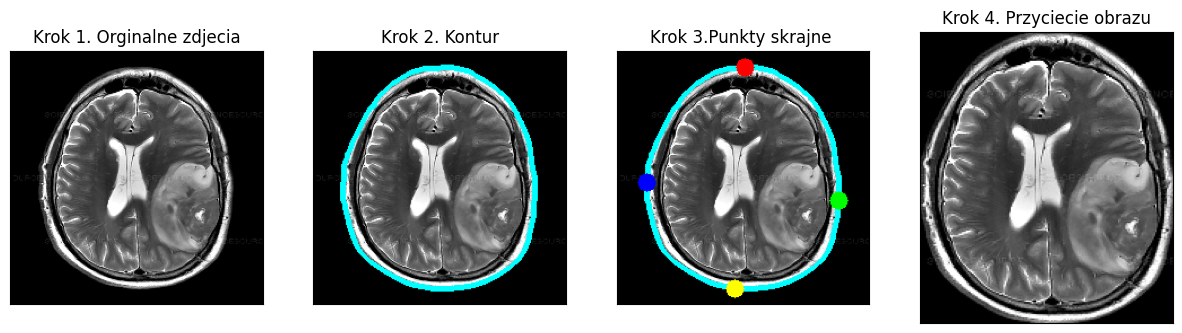

In [ ]:
# wykresy obrazujące poszczególne etapy przetwarzania przykładowego zdjęcia
plt.figure(figsize=(15,6))
plt.subplot(141)

# --------------------------------------------
# przekazanie przykładowego zdjęcia (orginalnego)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Krok 1. Orginalne zdjecia')


# --------------------------------------------
# przekazanie przykładowego zdjęcia z konturem
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Krok 2. Kontur')

# --------------------------------------------
# przekazanie przykładowego zdjęcia z zaznaczonymi punktami skrajnymi
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Krok 3.Punkty skrajne ')


# --------------------------------------------
# przekazanie przykładowego zdjęcia przyciętego
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Krok 4. Przyciecie obrazu')
plt.show()

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# utworzenie zmiennych pomocniczych referujących do znormalizowanych zdjęć (przyciętych)

X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

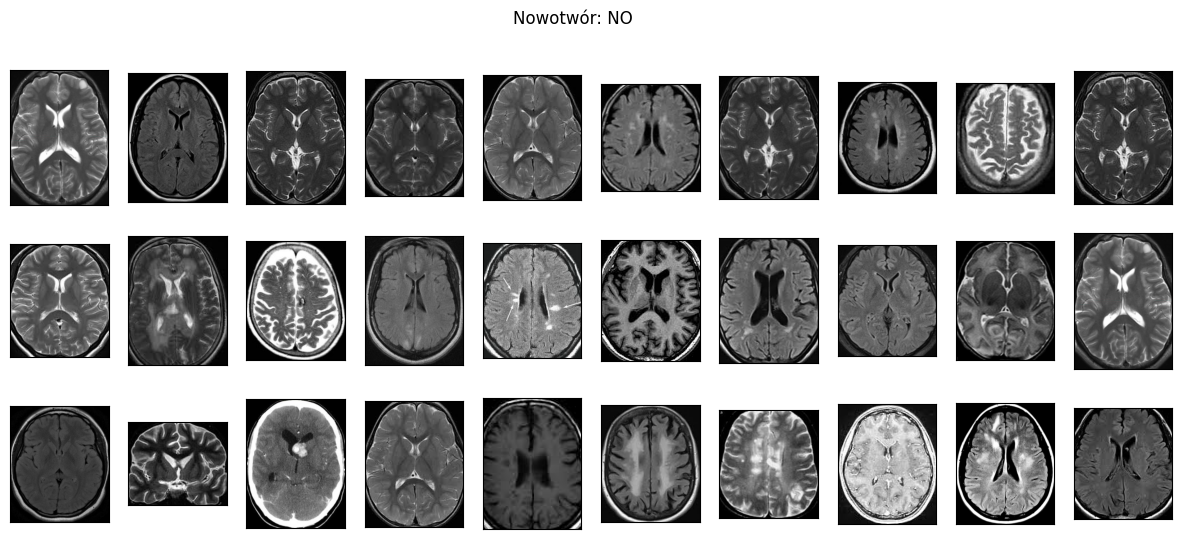

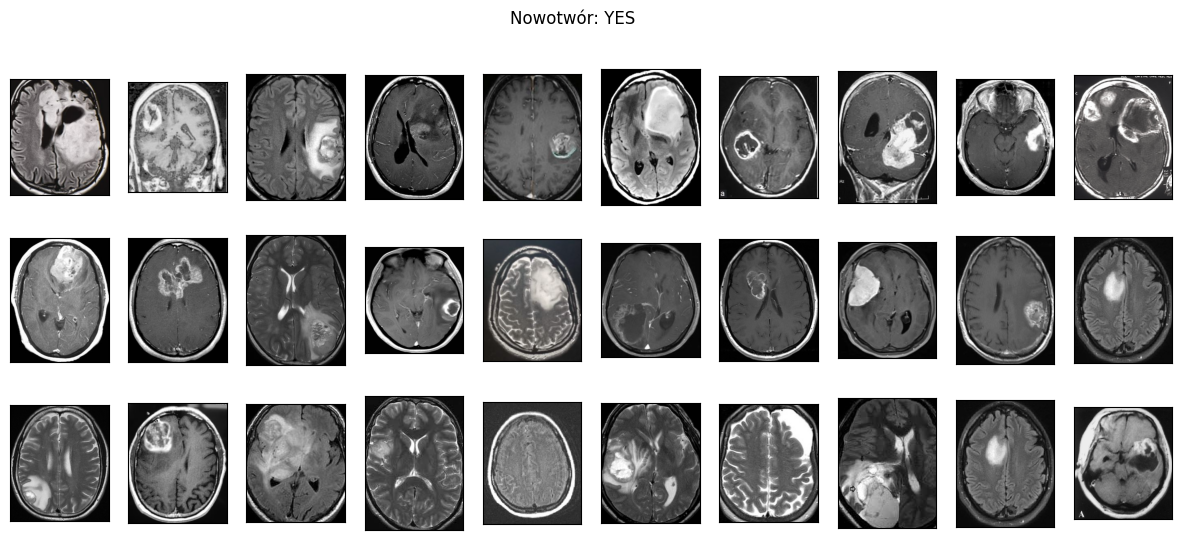

In [ ]:
nimg = 20 # liczba ozdjęć do wyswietlenia
plot_samples(X_train_crop, y_train, labels, nimg)

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# definicja pomocniczej funkcji do zapisu przyciętych zdjęć w nowej strukturze katalogowej maszyny wirtualnej

def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#zapisanie przyciętych obrazow do katalogów dedykowanych

!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


# ---- > sprawdzić zawartość struktur katalogowych *_CROP

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# TRANSFER LEARNING
# definicja pomocniczej funkcji (na potrzeby importowanego modelu konwolucyjnego VGG-15 )
def preprocess_imgs(set_name, img_size):
    """
    Zmiana rozmiaru i zastosowanie przetwarzania wstępnego VGG-15
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Utworzenie docelowych zmiennych z  przetowrzonymi zdjęciami dla modelu konwolucyjnego VGG-15

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

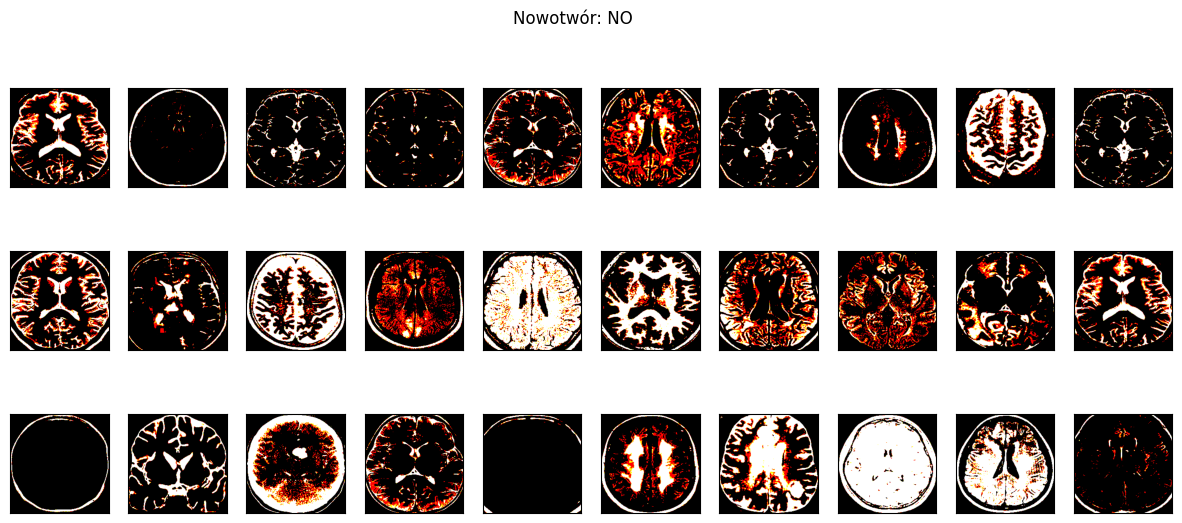

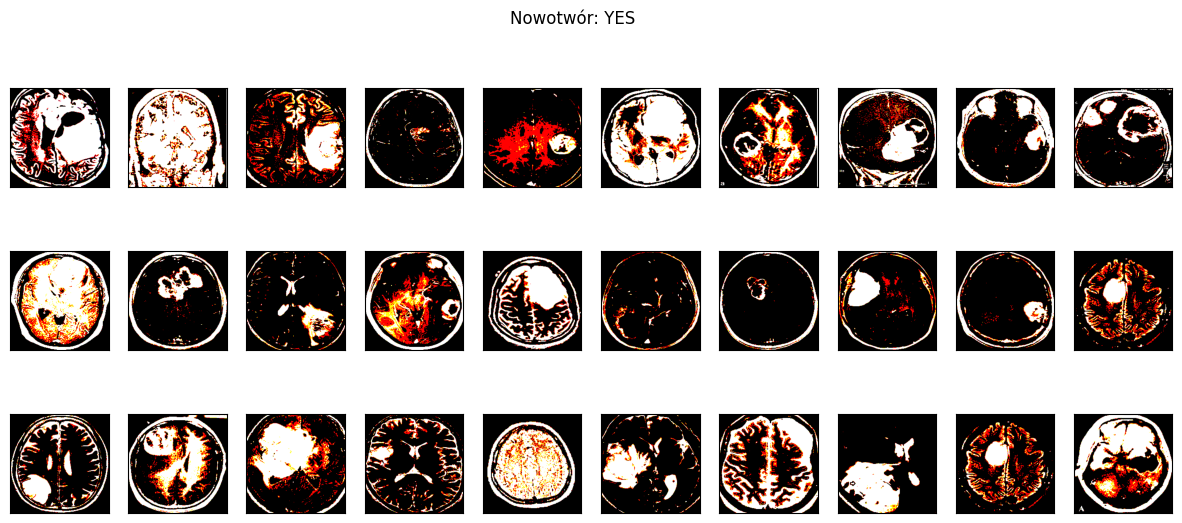

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# warnings.filterwarnings("ignore")
# wyświetlenie zdjęć z każdej klasyfikowanej grupy

# ZDJECIA kolorowe oraz znormalizowane pod względem kształtu i rozmiaru 224x 224

nimg = 20 # liczba ozdjęć do wyswietlenia
plot_samples(X_train_prep, y_train, labels, nimg)

In [ ]:
# 193 kolorowych zdjęci o wymiarze 224* 224
X_train_prep.shape

(193, 224, 224, 3)

**Przykładowa augmentacja na pojedynczym zdjeciu**

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ustawienie parametrów augmentacyjnych dla demonstracji procesu augmentacji
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,      # przesunięcie wzdłuż X
    height_shift_range=0.05,     # przesunięcie wzdłuż Y
    rescale=1./255,
    shear_range=0.05,            # przycinanie obrazu
    brightness_range=[0.1, 1.5], # rozjaśnianie/przyciemnianie
    horizontal_flip=True,        # odwrócenie poziome
    vertical_flip=True           # odwrócenie pionie
)

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# stworzenie pomocniczego katalogu 'preview' , w którym zostaną zapisane demonstracyjne wyniki augmentacji na jednym zdjęciu

os.mkdir('preview')

# przykladowe zdjęcie
x = X_train_crop[0]
#-------------------------

x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

# ---- > sprawdzić zawartość struktury katalogowej 'preview'

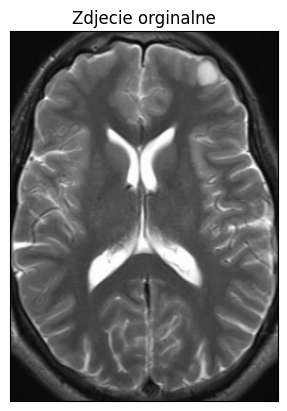

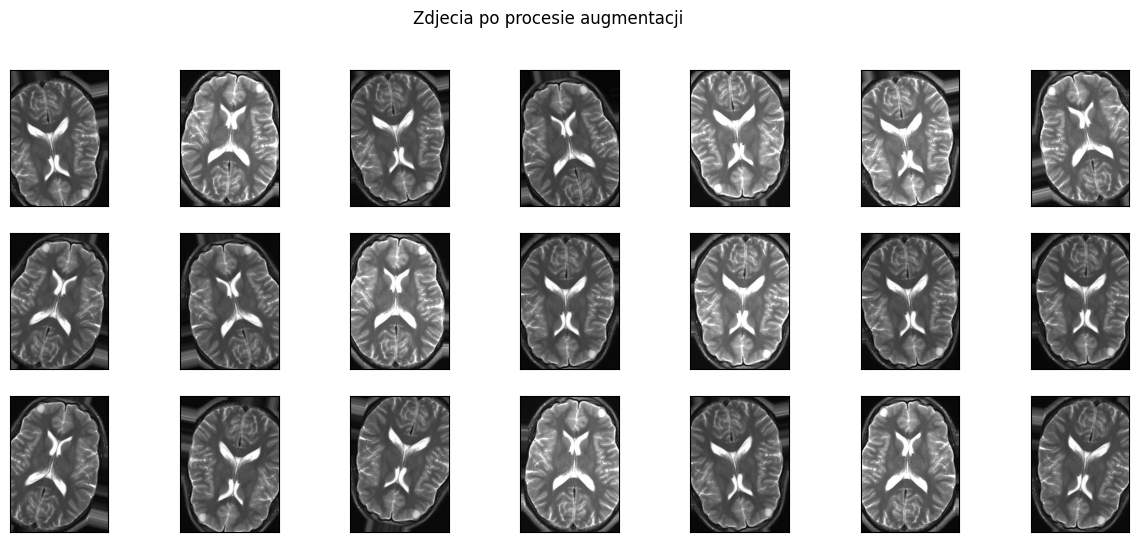

In [ ]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Zdjecie orginalne')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Zdjecia po procesie augmentacji ')
plt.show()

**Przygotowanie generatora danych wejściowych na czas uczenia modelu**

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

#--------------------------------------------------------
# dla danych treningowych

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,           # przesunięcie wzdłuż x
    height_shift_range=0.1,          # przesunięcie wzdłuż y
    shear_range=0.1,                 # przycięcie
    brightness_range=[0.5, 1.5],     # przyciemnienie/rozjaśninie
    horizontal_flip=True,            # odwrócenie poziome
    vertical_flip=True,              # odwrócenie pionowe
    preprocessing_function=preprocess_input
)


#--------------------------------------------------------
# dla danych testowych
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
#--------------------------------------------------------


# definicja treningowej(dla danych treningowych)  warstwy augmentacyjnej
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

# definicja testowej(dla danych ttestowych)  warstwy augmentacyjnej
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


**Załadowanie wstępnie wytrenowanego  modelu VGG16**

In [ ]:
vgg16_weight_path = '/content/drive/MyDrive/dane/modele/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [ ]:
base_model.summary()


# IMG_SIZE = 224 * 224

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

'{"class_name": "Functional", "config": {"name": "vgg16", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "block1_conv1", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constra

In [ ]:
base_model.to_json()

**Budowa modelu docelowego**

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(units = 128 , activation = 'relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(512,  activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))


#-------------------------------------------------
# WAZNE
model.layers[0].trainable = False
#--------------------------------------------------



model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4), # rozszerzenie algorytmu Stochastic Gradient Descent (SGD), gdzie  jest wykorzystywany gradient z  dostosowywaniem rozmiaru kroku indywidualnie dla każdej wagi.
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 128

**Proces uczenia modelu**

In [ ]:
#EPOCHS = 30
EPOCHS = 50
es = EarlyStopping(
    monitor='accuracy',
    mode='max', #  w trybie "max" zatrzyma się, gdy monitorowana wielkość(tu accuracy) przestanie rosnąć
    patience=6 #  liczba epok bez poprawy, po której trening zostanie zatrzymany
)

history = model.fit(
    train_generator,
   # steps_per_epoch=50, #50
    epochs=EPOCHS,
    validation_data=validation_generator,
   # validation_steps=25, # 25
    #callbacks=[es]
)

Epoch 1/50
7/7 [==============================] - 4s 482ms/step - loss: 13.8927 - accuracy: 0.5544 - val_loss: 12.0293 - val_accuracy: 0.6200
Epoch 2/50
7/7 [==============================] - 3s 388ms/step - loss: 5.0309 - accuracy: 0.6891 - val_loss: 0.9515 - val_accuracy: 0.9200
Epoch 3/50
7/7 [==============================] - 3s 406ms/step - loss: 5.1225 - accuracy: 0.7202 - val_loss: 0.5883 - val_accuracy: 0.9200
Epoch 4/50
7/7 [==============================] - 3s 366ms/step - loss: 3.9755 - accuracy: 0.7358 - val_loss: 0.9750 - val_accuracy: 0.8400
Epoch 5/50
7/7 [==============================] - 3s 384ms/step - loss: 3.9215 - accuracy: 0.7461 - val_loss: 1.2598 - val_accuracy: 0.8400
Epoch 6/50
7/7 [==============================] - 3s 376ms/step - loss: 3.7942 - accuracy: 0.7513 - val_loss: 0.3898 - val_accuracy: 0.9000
Epoch 7/50
7/7 [==============================] - 3s 490ms/step - loss: 3.1858 - accuracy: 0.7927 - val_loss: 0.4093 - val_accuracy: 0.8800
Epoch 8/50
7/7 [==

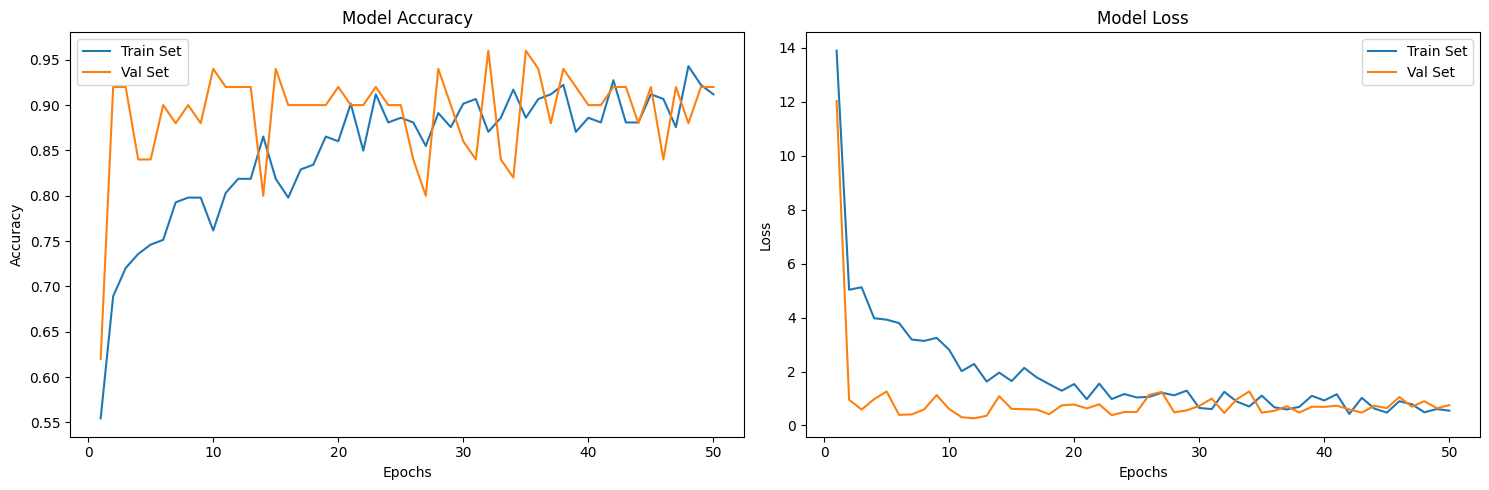

In [ ]:
# utworzenie wykresów  metryk procesu uczenia Accuracy i Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

**Ewaluacja modelu**

2/2 [==============================] - 0s 155ms/step
Val Accuracy = 0.94


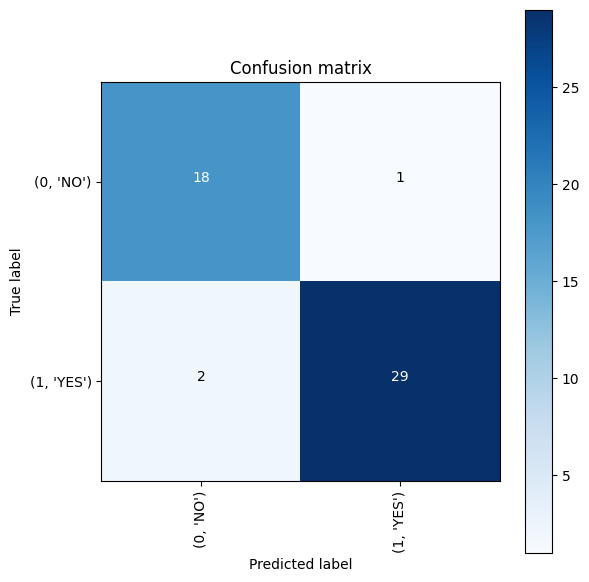

In [ ]:
# ewaluacja na zbiorze walidacyjnym
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

1/1 [==============================] - 0s 22ms/step
Test Accuracy = 0.80


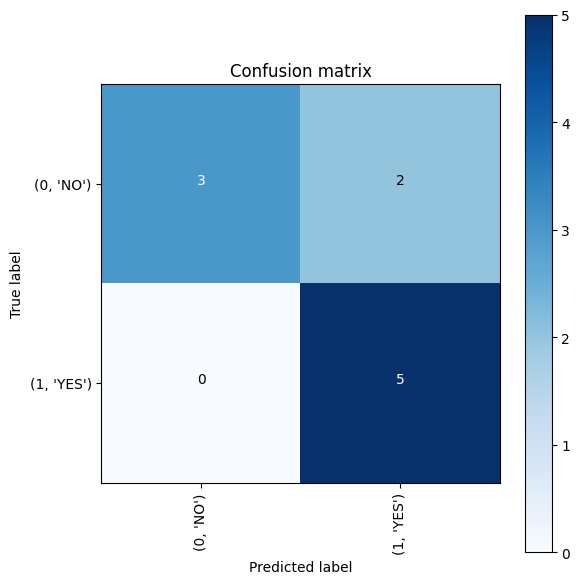

In [ ]:
# ewaluacja na zbiorze testowym
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

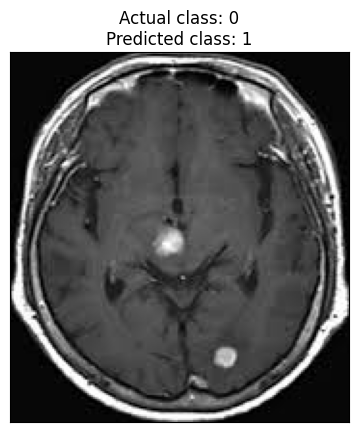

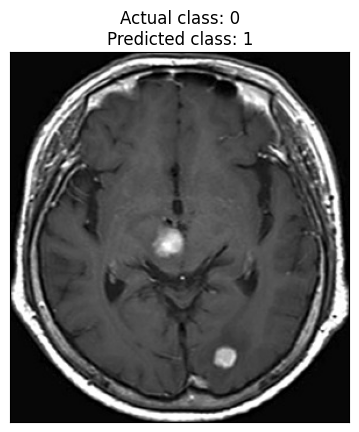

In [ ]:
# wykresy przypadków niepoprawnie sklasyfikowanych (ze bioru testowego)

ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('Brak błedów klasyfikacyjnych.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Rzeczywista  klasa: {y_val[i]}\n Wynik klasyfikacji: {predictions[i]}')
        plt.show()

In [ ]:
# clean up the space
#!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('2023-11-15_VGG_model.h5')